# WEBSITE OWNERSHIP NETWORK ANALYSIS

A script to help determine who owns a website, by mapping out the entire network and finding contacts.

Realises on data in Domain BigData to draw a network of website ownership direct-links. 



### IMPORTS

In [1]:
# libraries
import requests
from bs4 import BeautifulSoup, Tag
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import networkx as nx
import math

## SET UP

In [2]:
G = nx.DiGraph()
contact_list = []

In [3]:
# create DF. stores up to 10 lots of historic details per listing

columns=['Site']
terms = ['Name','Organisation','Email','Phone','Address','Fax']

for t in terms:
    columns.append('Registrant ' + t)
    columns.append('Registrant ' + t + ' URL')

historic_amount = 10
for n in range(0,historic_amount+1):
    for t in terms:
        columns.append('Historic ' + t + ' ' + str(n))
        columns.append('Historic ' + t + ' ' + str(n) + ' URL')

identifiersDF = pd.DataFrame(columns=columns)

In [4]:
exclude = ['None']

In [5]:
# THIS IS THE CHECKLIST OF SITES THAT WE WANT TO START WITH
checklist = ['betzona.cc',\
            'caribebet.cc',\
            'flashbet.cc',\
            'mustangbet.cc',\
            'luckydog.in',\
            'oceanside247.com',\
            'sportsaction77.com'
            ]

### FUNCTIONS

In [6]:
### Draws the graph and assigns color coding

def colorGraph(height):
    
    plt.figure(1,figsize=(18,height)) 
    pos = nx.spring_layout(G,k=0.5,iterations=150)
    
    color_map = []
    
    for node in G:
        
        if ".cc" in node:
            color_map.append('green')
        elif node == 'luckydog.in' or node == 'oceanside247.com' or node == 'sportsaction77.com':
            color_map.append('orange')            
        elif "@" in str(node) or "(at)" in str(node) or "+" in str(node):            #highlights web addresses
            color_map.append('yellow')
            contact_list.append(node)
        elif "." in str(node):
            if '@' not in str(node) or "(at)" not in str(node):                    #.com, .net, etc but not emails
                color_map.append('silver')
        else:
            color_map.append('blue')
            contact_list.append(node)
            
    node_sizes = [v*100 for k,v in dict(G.degree()).items()]
    
    for node, (x, y) in pos.items():
            gdegreen = 1 if dict(G.degree())[node] == 0 else dict(G.degree())[node]
            plt.text(x, y, str(node), fontsize=25 * math.log(gdegreen,(len(node_sizes))), ha='center', va='center')    
    
    nx.draw(G, pos, alpha=.5, with_labels=True, node_color=color_map, font_color="k", node_size=node_sizes, font_size=0)
    plt.show()
    
    print(G.nodes())

In [7]:
## For each site in the checklist, find's the current and historic registration details

def DBDsites(site):
    
    identifiersDF.at[site,'Site'] = site
      
    url = "https://domainbigdata.com/" + site 
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    print(url)
    
    def getInfo(idequals, dname, v1, bit_type):
                
        try:
            
            if bit_type == 'bit_soup':
                bit = soup.find(id=idequals)
            if bit_type == 'bit_historical':
                bit = historical[n].find(id=idequals)
            
            if v1 == 'TD1':    
                bit = bit.find_all("td")[1]
                                                
            # get URL    
            if bit.find('a') != None:
                bit = bit.find("a")
                                
                def infoURL(field):
                    if dname == field:
                        h = bit.get("href")
                        h = "https://domainbigdata.com" + h                    
                        identifiersDF.at[site,field + ' URL'] = h
                        
                for t in terms:
                    infoURL(dname)
                                    
            bit = bit.contents[0]

        except:
            bit = None
                    
        bit = str(bit)
                                
        identifiersDF.at[site,dname] = bit
        
    #run for each item
    getInfo("trRegistrantName", 'Registrant Name', 'TD1', 'bit_soup')
    getInfo('MainMaster_trRegistrantOrganization', 'Registrant Organisation', None, 'bit_soup')
    getInfo("trRegistrantEmail", 'Registrant Email', 'TD1', 'bit_soup')
    getInfo("trRegistrantTel", 'Registrant Phone', 'TD1', 'bit_soup')
    getInfo("trRegistrantAddress", 'Registrant Address', 'TD1', 'bit_soup')
    getInfo("trRegistrantFax", 'Registrant Fax', 'TD1', 'bit_soup')
    
    historical = soup.find_all(id='divRptHistoryMain')
    lh = 1 if len(historical) == 0 else len(historical)                #### doesn't do th 'historical-amount' - as it doesn't need to. That is an inflated number - inflated so it catches everything in here. 
    for n in range(0,lh):
        getInfo("trRegistrantNameInRpt", 'Historic Name ' + str(n), 'TD1', 'bit_historical')
        getInfo('MainMaster_rptWhoisHistory_trRegistrantOrganizationInRpt_' + str(n), 'Historic Org ' + str(n), 'TD1', 'bit_historical')
        getInfo('trRegistrantEmailInRpt', 'Historic Email ' + str(n), 'TD1', 'bit_historical')
        getInfo('trRegistrantAddressInRpt', 'Historic Address ' + str(n), 'TD1', 'bit_historical')
        getInfo('trRegistrantTelInRpt', 'Historic Phone ' + str(n), 'TD1', 'bit_historical')
        getInfo('trRegistrantFaxInRpt', 'Historic Fax ' + str(n), 'TD1', 'bit_historical')
          

def findSiteOwner():
    
    checklist = stopRepeatsCL()

    for site in checklist: 
        DBDsites(site)  
        
    addOwnerNode()  

In [8]:
## Attaches registration info to site-nodes

def addOwnerNode():
    
    def regNodes(field1, field2, conx):
    
        temp = identifiersDF[[field1, field2]].dropna()
        temp = temp[temp[field1].isin(exclude) == False]
        temp = temp[temp[field2].isin(exclude) == False]
    
        for index, row in temp.iterrows():
            a = row[field1]
            b = row[field2]
            G.add_node(a)
            G.add_edge(a,b, connection = conx)
    
    # run reg nodes
    for t in terms:
        regNodes('Site', 'Registrant ' + t, 'current_reg')
                
    for n in range(0,historic_amount+1):
        for t in terms:
            try:
                x = 'Historic ' + t + ' ' + str(n) 
                regNodes('Site', x, 'his_reg' + str(n))
            except:
                pass
        
    colorGraph(12)

In [9]:
# for killing nodes / puttng in exclude list

def killNodes(kill):
    for k in kill:
        G.remove_node(k)
        exclude.append(k)
        if k in checklist:
            checklist.remove(k)
            print('removed from checklist: ', k)

#keeps node but doesn't search
def muteNodes(kill):
    for k in kill:
        exclude.append(k)

In [10]:
# Finds other sites owned by a registrant

def DBDowner(url, node):
        page = requests.get(url)                                
        soup = BeautifulSoup(page.content, 'html.parser')
        j = soup.find_all(id='aDomain')
        for i in j:
            site = i.contents[0]
            G.add_edge(site, node, connection='owned_by')  
            checklist.append(site)   #### add these sites to the checklist because we need to check all of them for owners
            
def ownerNodes(fieldURL, fieldNODE):
    
    temp = identifiersDF[[fieldURL, fieldNODE]].dropna()
    temp = temp[temp[fieldNODE].isin(exclude) == False]
    
    for index, row in temp[[fieldNODE,fieldURL]].dropna().iterrows():
        a = row[fieldURL]
        b = row[fieldNODE]
        DBDowner(a, b)
             
def findOwnerSites():
    
    checklist = []
    
    for t in terms:
        item = 'Registrant ' + t
        ownerNodes(item + ' URL', item)
            
    for n in range(0,historic_amount+1):
        for t in terms:
            item = 'Historic ' + t + ' ' + str(n)
            ownerNodes(item + ' URL', item)
                
    colorGraph(12)

In [11]:
def stopRepeatsCL():
    l = np.unique(checklist).tolist()
    l = [x for x in l if x not in exclude]
    [l.remove(i) for i in l if i in list(identifiersDF['Site'])]                  
    return l

# RUN
### First Round

In [12]:
### MANUALLY ADDING RELEVANT EDGES TO GET THIS STARTED
G.add_edge('flashbet.cc','oceanside247.com', connection='in_code')                         #COPYRIGHT OCEANSIDE247.COM FOUND IN CODE
G.add_edge('caribebet.cc','oceanside247.com', connection='in_code')                    
G.add_edge('mustangbet.cc','oceanside247.com', connection='in_code')
G.add_edge('betzona.cc','oceanside247.com', connection='in_code')
G.add_edge('mustangbet.cc','luckydog.in', connection='in_code')                            #USES STYLESHEET FROM LUCKYDOG.IN - AND LOOKS THE SAME
G.add_edge('luckydog.in','sportsaction77.com', connection='in_code')                       #USES STYLESHEET FROM SPORTSACTION77.COM - AND LOOKS THE SAME
G.add_edge('oceanside247.com','sportsaction77.com', connection='in_code')
G.add_edge('mustangbet.cc','sportsaction77.com', connection='in_code')
G.add_edge('betzona.cc','sportsaction77.com', connection='in_code')
G.add_edge('caribebet.cc','sportsaction77.com', connection='in_code')
G.add_edge('flashbet.cc','sportsaction77.com', connection='in_code')

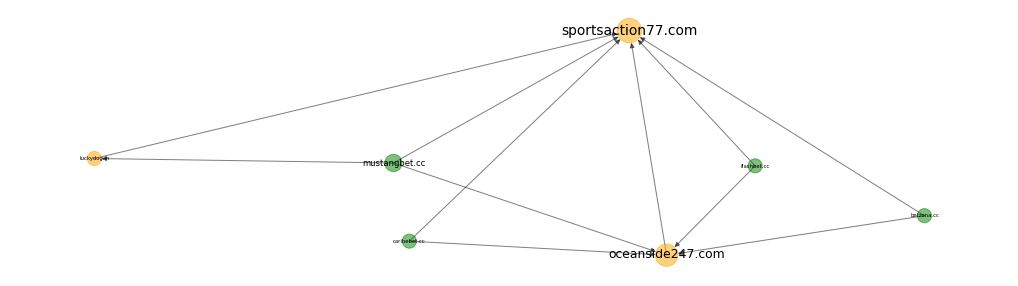

['flashbet.cc', 'oceanside247.com', 'caribebet.cc', 'mustangbet.cc', 'betzona.cc', 'luckydog.in', 'sportsaction77.com']


In [13]:
colorGraph(5)

https://domainbigdata.com/betzona.cc
https://domainbigdata.com/caribebet.cc
https://domainbigdata.com/flashbet.cc
https://domainbigdata.com/luckydog.in
https://domainbigdata.com/mustangbet.cc
https://domainbigdata.com/oceanside247.com
https://domainbigdata.com/sportsaction77.com


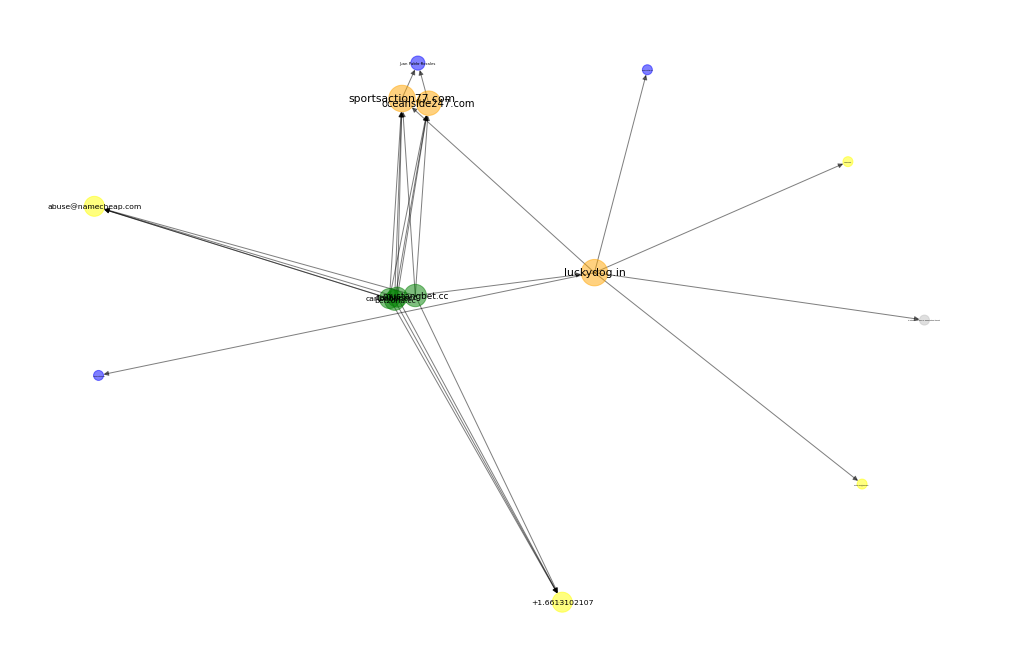

['flashbet.cc', 'oceanside247.com', 'caribebet.cc', 'mustangbet.cc', 'betzona.cc', 'luckydog.in', 'sportsaction77.com', 'Francisco Altamirano', 'Juan Pablo Rosales', 'Atamirano Enterpraises', 'abuse@namecheap.com', 'fran.altamirano(at)yahoo.com', '+1.6613102107', '+1.8183457689', 'Av. Zeta de Cochero 403-44 col. Reserva Territorial Atlixcayotl']


,Site,Registrant Name,Registrant Name URL,Registrant Organisation,Registrant Organisation URL,Registrant Email,Registrant Email URL,Registrant Phone,Registrant Phone URL,Registrant Address,...,Historic Email 10,Historic Email 10 URL,Historic Phone 10,Historic Phone 10 URL,Historic Address 10,Historic Address 10 URL,Historic Fax 10,Historic Fax 10 URL,Historic Org 0,Historic Org 0 URL
betzona.cc,betzona.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
caribebet.cc,caribebet.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
flashbet.cc,flashbet.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
luckydog.in,luckydog.in,Francisco Altamirano,https://domainbigdata.com/nj/1fIjpu-K1eIqJBiVN...,Atamirano Enterpraises,https://domainbigdata.com/nj/3iQKnRVoGBDVEN1OT...,fran.altamirano(at)yahoo.com,NaN,+1.8183457689,NaN,Av. Zeta de Cochero 403-44 col. Reserva Territ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atamirano Enterpraises,https://domainbigdata.com/nj/3iQKnRVoGBDVEN1OT...
mustangbet.cc,mustangbet.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
oceanside247.com,oceanside247.com,Juan Pablo Rosales,https://domainbigdata.com/nj/uv-MeAI6bqoQg0bC5...,None,NaN,None,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
sportsaction77.com,sportsaction77.com,Juan Pablo Rosales,https://domainbigdata.com/nj/uv-MeAI6bqoQg0bC5...,None,NaN,None,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [14]:
findSiteOwner()
identifiersDF

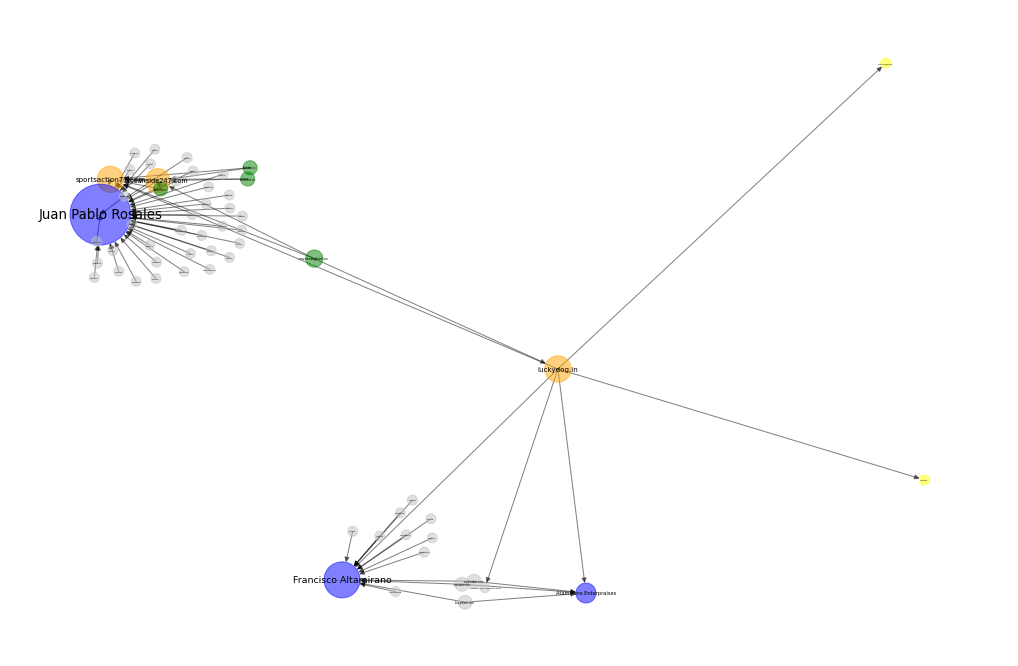

['flashbet.cc', 'oceanside247.com', 'caribebet.cc', 'mustangbet.cc', 'betzona.cc', 'luckydog.in', 'sportsaction77.com', 'Francisco Altamirano', 'Juan Pablo Rosales', 'Atamirano Enterpraises', 'fran.altamirano(at)yahoo.com', '+1.8183457689', 'Av. Zeta de Cochero 403-44 col. Reserva Territorial Atlixcayotl', 'eyeunique.com', 'royalmaker.com', 'dauplaza.com', 'imagetipspanama.com', 'sharpdime.com', 'eyeuniqueoptique.com', 'terraccini.com', 'zonabienes.com', 'iuniqueoptique.com', 'centrodenegociosgye.com', 'costabet.com', 'cadpapers.com', 'apptitudecr.com', 'genesiscr.net', 'play676.com', 'playallsports77.com', 'playocean88.com', 'quickyventas.com', 'winwagering.com', 'youbet99.com', '4quarterzpayperhead.com', '4quarterzpriceperhead.com', 'internationalsbet.com', 'titaniumsports.net', 'aloha22.com', 'mex-bet.com', 'kirbybet.com', 'betcostapro.com', 'sweetaction42.com', 'tobysports.net', 'donganon.com', '4quarterz.com', 'redhotsports20.com', 'chefenunclick.com', 'betbanks2.com', 'taksports.

,Site,Registrant Name,Registrant Name URL,Registrant Organisation,Registrant Organisation URL,Registrant Email,Registrant Email URL,Registrant Phone,Registrant Phone URL,Registrant Address,...,Historic Email 10,Historic Email 10 URL,Historic Phone 10,Historic Phone 10 URL,Historic Address 10,Historic Address 10 URL,Historic Fax 10,Historic Fax 10 URL,Historic Org 0,Historic Org 0 URL
betzona.cc,betzona.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
caribebet.cc,caribebet.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
flashbet.cc,flashbet.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
luckydog.in,luckydog.in,Francisco Altamirano,https://domainbigdata.com/nj/1fIjpu-K1eIqJBiVN...,Atamirano Enterpraises,https://domainbigdata.com/nj/3iQKnRVoGBDVEN1OT...,fran.altamirano(at)yahoo.com,NaN,+1.8183457689,NaN,Av. Zeta de Cochero 403-44 col. Reserva Territ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atamirano Enterpraises,https://domainbigdata.com/nj/3iQKnRVoGBDVEN1OT...
mustangbet.cc,mustangbet.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
oceanside247.com,oceanside247.com,Juan Pablo Rosales,https://domainbigdata.com/nj/uv-MeAI6bqoQg0bC5...,None,NaN,None,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
sportsaction77.com,sportsaction77.com,Juan Pablo Rosales,https://domainbigdata.com/nj/uv-MeAI6bqoQg0bC5...,None,NaN,None,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [15]:
killNodes(['abuse@namecheap.com', '+1.6613102107',])

findOwnerSites()
identifiersDF

### Second Round

In [16]:
killNodes(['eyeunique.com','imagetipspanama.com', 'genesiscr.net', 'cadpapers.com',  'eyeuniqueoptique.com', 'terraccini.com', 'iuniqueoptique.com', 'centrodenegociosgye.com', 'promoadictos.com', '4quarterzpayperhead.com', '4quarterzpriceperhead.com',  'chefenunclick.com', 'imeicloud.us', 'demotest.me', 'vipapuestas.me',])

removed from checklist:  eyeunique.com
removed from checklist:  imagetipspanama.com
removed from checklist:  genesiscr.net
removed from checklist:  cadpapers.com
removed from checklist:  eyeuniqueoptique.com
removed from checklist:  terraccini.com
removed from checklist:  iuniqueoptique.com
removed from checklist:  centrodenegociosgye.com
removed from checklist:  promoadictos.com
removed from checklist:  4quarterzpayperhead.com
removed from checklist:  4quarterzpriceperhead.com
removed from checklist:  chefenunclick.com
removed from checklist:  imeicloud.us
removed from checklist:  demotest.me
removed from checklist:  vipapuestas.me


https://domainbigdata.com/4quarterz.com
https://domainbigdata.com/acecasinomx.com
https://domainbigdata.com/aloha22.com
https://domainbigdata.com/apptitudecr.com
https://domainbigdata.com/betbanks2.com
https://domainbigdata.com/betcostapro.com
https://domainbigdata.com/betpitbull.com
https://domainbigdata.com/caribebet.cc
https://domainbigdata.com/costabet.com
https://domainbigdata.com/dauplaza.com
https://domainbigdata.com/donganon.com
https://domainbigdata.com/fwcsport.com
https://domainbigdata.com/internationalsbet.com
https://domainbigdata.com/intheactionnow.com
https://domainbigdata.com/kirbybet.com
https://domainbigdata.com/mex-bet.com
https://domainbigdata.com/nickelonit.com
https://domainbigdata.com/play676.com
https://domainbigdata.com/playallsports77.com
https://domainbigdata.com/playmoka.com
https://domainbigdata.com/playocean88.com
https://domainbigdata.com/quickyventas.com
https://domainbigdata.com/redhotsports20.com
https://domainbigdata.com/royalmaker.com
https://domainb

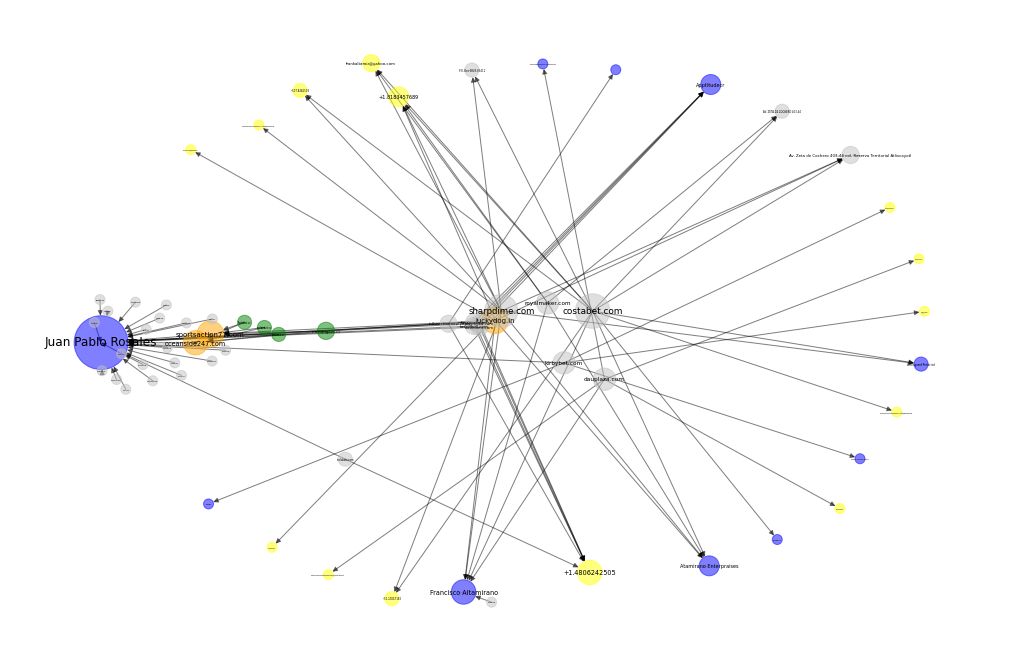

['flashbet.cc', 'oceanside247.com', 'caribebet.cc', 'mustangbet.cc', 'betzona.cc', 'luckydog.in', 'sportsaction77.com', 'Francisco Altamirano', 'Juan Pablo Rosales', 'Atamirano Enterpraises', 'fran.altamirano(at)yahoo.com', '+1.8183457689', 'Av. Zeta de Cochero 403-44 col. Reserva Territorial Atlixcayotl', 'royalmaker.com', 'dauplaza.com', 'sharpdime.com', 'zonabienes.com', 'costabet.com', 'apptitudecr.com', 'play676.com', 'playallsports77.com', 'playocean88.com', 'quickyventas.com', 'winwagering.com', 'youbet99.com', 'internationalsbet.com', 'titaniumsports.net', 'aloha22.com', 'mex-bet.com', 'kirbybet.com', 'betcostapro.com', 'sweetaction42.com', 'tobysports.net', 'donganon.com', '4quarterz.com', 'redhotsports20.com', 'betbanks2.com', 'taksports.net', 'acecasinomx.com', 'betpitbull.com', 'intheactionnow.com', 'nickelonit.com', 'fwcsport.com', 'toolsbets.com', 'playmoka.com', 'Whoisguard Protected', 'Apptitudecr', 'Whoisguard Inc', '\n', '99633789fdd545578f3f408210e8d594.protect(at)wh

In [17]:
findSiteOwner()

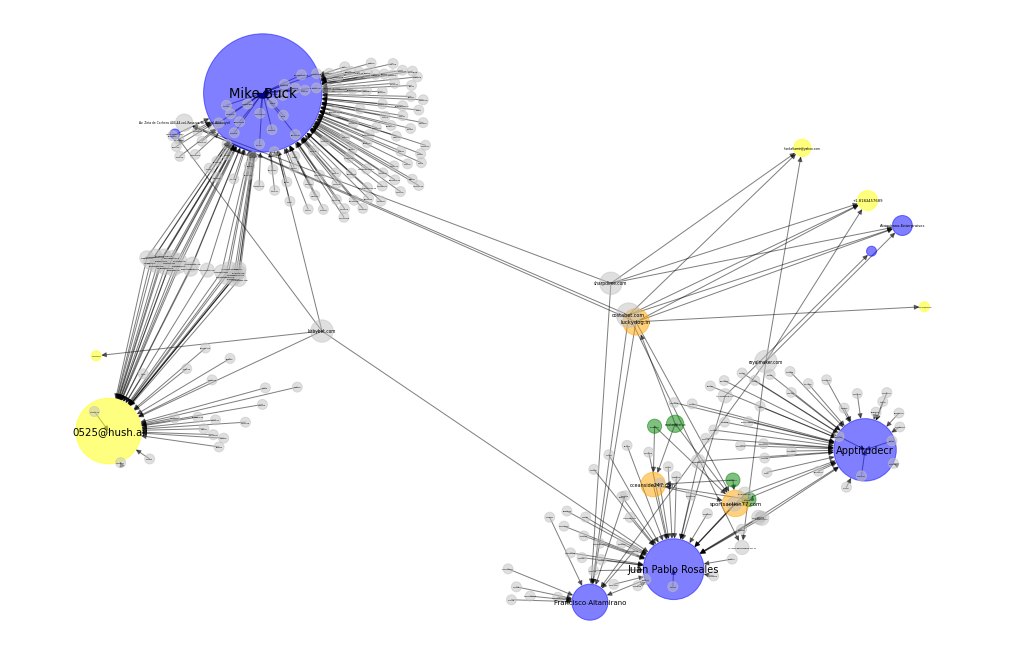

['flashbet.cc', 'oceanside247.com', 'caribebet.cc', 'mustangbet.cc', 'betzona.cc', 'luckydog.in', 'sportsaction77.com', 'Francisco Altamirano', 'Juan Pablo Rosales', 'Atamirano Enterpraises', 'fran.altamirano(at)yahoo.com', '+1.8183457689', 'Av. Zeta de Cochero 403-44 col. Reserva Territorial Atlixcayotl', 'royalmaker.com', 'dauplaza.com', 'sharpdime.com', 'zonabienes.com', 'costabet.com', 'apptitudecr.com', 'play676.com', 'playallsports77.com', 'playocean88.com', 'quickyventas.com', 'winwagering.com', 'youbet99.com', 'internationalsbet.com', 'titaniumsports.net', 'aloha22.com', 'mex-bet.com', 'kirbybet.com', 'betcostapro.com', 'sweetaction42.com', 'tobysports.net', 'donganon.com', '4quarterz.com', 'redhotsports20.com', 'betbanks2.com', 'taksports.net', 'acecasinomx.com', 'betpitbull.com', 'intheactionnow.com', 'nickelonit.com', 'fwcsport.com', 'toolsbets.com', 'playmoka.com', 'Apptitudecr', '\n', 'frankaltamir@yahoo.com', 'AV. ZETA DE COCHERO 403-44', 'Mike Buck', '0525@hush.ai', '+50

In [18]:
killNodes(['Whoisguard Protected', 'Whoisguard Inc', 'Obfuscated whois Gandi-63-65 boulevard Massena', '+51.17057182', '+33.170377666', '+507.8365503', '+1.4806242505', '+33.143730576', 'P.O. Box 0823-03411', '+1.5555555555', ])
killNodes(['66b6458b10cfb4aca5b90bfb3a5bc0ff-5638524(at)contact.gandi.net', '99633789fdd545578f3f408210e8d594.protect(at)whoisguard.com', 'ad1e4c9e4b5240cb96c2e187c356f496.protect(at)whoisguard.com',])

findOwnerSites()

### Third Round

removed from checklist:  laotto.info
removed from checklist:  mytankinfo.com
removed from checklist:  perheadgambling.com
removed from checklist:  wrk41.com
removed from checklist:  newenglandwoodworks.com
removed from checklist:  ocsdec73.com
removed from checklist:  buycrx.com
removed from checklist:  mcbconsulting.com
removed from checklist:  mjb-infotech.com
removed from checklist:  mikebuckphotography.com
removed from checklist:  finsources.com
removed from checklist:  crrentals09.com
removed from checklist:  ezwallet.net
removed from checklist:  genevacommunitycenter.com
removed from checklist:  forthrightech.com
removed from checklist:  igadvisors.net
removed from checklist:  brhistory.com
removed from checklist:  gurupropertymanagement.com
removed from checklist:  deansfleamarketandfurniture.com
removed from checklist:  ddosexperts.com
removed from checklist:  securemailcr.info
removed from checklist:  506mail.com
removed from checklist:  delmar555.com
removed from checklist:  

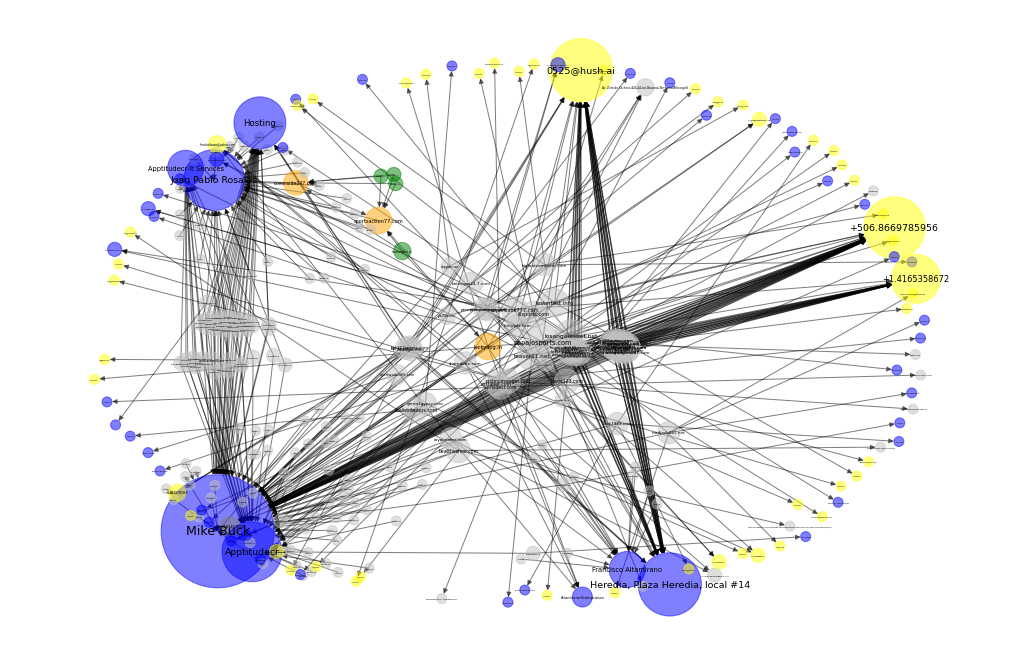

['flashbet.cc', 'oceanside247.com', 'caribebet.cc', 'mustangbet.cc', 'betzona.cc', 'luckydog.in', 'sportsaction77.com', 'Francisco Altamirano', 'Juan Pablo Rosales', 'Atamirano Enterpraises', 'fran.altamirano(at)yahoo.com', '+1.8183457689', 'Av. Zeta de Cochero 403-44 col. Reserva Territorial Atlixcayotl', 'royalmaker.com', 'dauplaza.com', 'sharpdime.com', 'zonabienes.com', 'costabet.com', 'apptitudecr.com', 'play676.com', 'playallsports77.com', 'playocean88.com', 'quickyventas.com', 'winwagering.com', 'youbet99.com', 'internationalsbet.com', 'titaniumsports.net', 'aloha22.com', 'mex-bet.com', 'kirbybet.com', 'betcostapro.com', 'sweetaction42.com', 'tobysports.net', 'donganon.com', '4quarterz.com', 'redhotsports20.com', 'betbanks2.com', 'taksports.net', 'acecasinomx.com', 'betpitbull.com', 'intheactionnow.com', 'nickelonit.com', 'fwcsport.com', 'toolsbets.com', 'playmoka.com', 'Apptitudecr', '\n', 'frankaltamir@yahoo.com', 'AV. ZETA DE COCHERO 403-44', 'Mike Buck', '0525@hush.ai', '+50

,Site,Registrant Name,Registrant Name URL,Registrant Organisation,Registrant Organisation URL,Registrant Email,Registrant Email URL,Registrant Phone,Registrant Phone URL,Registrant Address,...,Historic Address 10,Historic Address 10 URL,Historic Fax 10,Historic Fax 10 URL,Historic Org 0,Historic Org 0 URL,Historic Org 1 URL,Historic Org 1,Historic Org 2,Historic Org 2 URL
betzona.cc,betzona.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
caribebet.cc,caribebet.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
flashbet.cc,flashbet.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
luckydog.in,luckydog.in,Francisco Altamirano,https://domainbigdata.com/nj/1fIjpu-K1eIqJBiVN...,Atamirano Enterpraises,https://domainbigdata.com/nj/3iQKnRVoGBDVEN1OT...,fran.altamirano(at)yahoo.com,NaN,+1.8183457689,NaN,Av. Zeta de Cochero 403-44 col. Reserva Territ...,...,NaN,NaN,NaN,NaN,Atamirano Enterpraises,https://domainbigdata.com/nj/3iQKnRVoGBDVEN1OT...,NaN,NaN,NaN,NaN
mustangbet.cc,mustangbet.cc,None,NaN,None,NaN,abuse@namecheap.com,https://domainbigdata.com/namecheap.com/mj/ZTB...,+1.6613102107,NaN,None,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wc107.com,wc107.com,None,NaN,None,NaN,None,NaN,+1.4806242505,NaN,None,...,NaN,NaN,NaN,NaN,None,NaN,https://domainbigdata.com/nj/CJwSIrdArxJ5m7SZ5...,Hosting,Hosting,https://domainbigdata.com/nj/CJwSIrdArxJ5m7SZ5...
wc72.com,wc72.com,Mike Buck,https://domainbigdata.com/nj/vV0krAW8E0v-E3KAT...,Mike Buck,https://domainbigdata.com/nj/vV0krAW8E0v-E3KAT...,0525@hush.ai,https://domainbigdata.com/hush.ai/mj/yYB2WIrZe...,+506.8669785956,NaN,"Heredia, Plaza Heredia, local #14",...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
winningwagers247.com,winningwagers247.com,Mike Buck,https://domainbigdata.com/nj/vV0krAW8E0v-E3KAT...,Mike Buck,https://domainbigdata.com/nj/vV0krAW8E0v-E3KAT...,0525@hush.ai,https://domainbigdata.com/hush.ai/mj/yYB2WIrZe...,+506.8669785956,NaN,"Heredia, Plaza Heredia, local #14",...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
worldofaction.com,worldofaction.com,Mike Buck,https://domainbigdata.com/nj/vV0krAW8E0v-E3KAT...,Mike Buck,https://domainbigdata.com/nj/vV0krAW8E0v-E3KAT...,0525@hush.ai,https://domainbigdata.com/hush.ai/mj/yYB2WIrZe...,+506.8669785956,NaN,"Heredia, Plaza Heredia, local #14",...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN


In [19]:
killNodes(['laotto.info','mytankinfo.com','perheadgambling.com','wrk41.com','newenglandwoodworks.com','ocsdec73.com','buycrx.com','mcbconsulting.com','mjb-infotech.com','mikebuckphotography.com','finsources.com','crrentals09.com','ezwallet.net','genevacommunitycenter.com','forthrightech.com','igadvisors.net','brhistory.com','gurupropertymanagement.com','deansfleamarketandfurniture.com','ddosexperts.com','securemailcr.info','506mail.com','delmar555.com','ec-investor.com', 'bucktheworld.com','betwillyd.com', 'europph.com', 'wetahook247.com', 'tiffanyandmichael.com', 'mcbfleetmanagementconsulting.com', 'testbetbuckeyesports.com', 'rulestothegame.com', 'peachbets.com', 'thedog365.com', ])
findSiteOwner()
identifiersDF

## LIST OF SITES TO CHECK

In [23]:
#turn nodes into a list. then filter out the dead links and the non gambling ones

temp = [x for x in G.nodes() if '.' in x and '+' not in x and '(at)' not in x and '@' not in x and ' ' not in x]
sites_to_check = []
for l in temp:
    url = 'https://' + l    
    try:
        page = requests.get(url)                                
        soup = BeautifulSoup(page.content, 'html.parser')
        if 'bet' in str(soup) or 'casino' in str(soup) or '//assets.becoms.co/banner.html' in str(soup) or 'Sportsbook' in str(soup):
            sites_to_check.append(l)
    except:
        pass

In [25]:
sites_to_check

['flashbet.cc',
 'oceanside247.com',
 'caribebet.cc',
 'mustangbet.cc',
 'betzona.cc',
 'luckydog.in',
 'sportsaction77.com',
 'royalmaker.com',
 'sharpdime.com',
 'costabet.com',
 'play676.com',
 'playocean88.com',
 'winwagering.com',
 'youbet99.com',
 'aloha22.com',
 'sweetaction42.com',
 'tobysports.net',
 '4quarterz.com',
 'betbanks2.com',
 'taksports.net',
 'nickelonit.com',
 'fwcsport.com',
 'playmoka.com',
 'demotest.me',
 'vipapuestas.me',
 'surfsidecr.com',
 'brothersvip.com',
 '22aloha.com',
 'ufc50.com',
 'securebookie.com',
 'luckybuck101.com',
 'juega123.com',
 'green4gypsy.com',
 'cocalsports.net',
 'sportsplay2.com',
 'grancasinobet.com',
 'bets999.net',
 'vegasoffshore.net',
 'liveplaytoday.com',
 'sportsinfo27.com',
 'livescorecr.com',
 'infosports19.com',
 'ipconnectcr.com',
 '182ip.com',
 '24fantasysports.com',
 'worldofaction.com',
 '5bets.net',
 'vegaslive365.com',
 'uplay247.com',
 'bet702sports.net',
 'betbuckeyesports.net',
 'betemnow.com',
 'betemnow.net',
 'be